In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
import torch
from transformers import BertTokenizer,BertForSequenceClassification,Trainer,TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from torch.utils.data import dataloader
from datasets import Dataset

In [4]:
import spacy
Preprocessing_Pipeline=spacy.load("en_core_web_sm")

In [5]:
df=pd.read_csv("/content/Combined Data.csv")

In [6]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
df.drop(columns=["Unnamed: 0"],inplace=True)

In [8]:
df.isnull().sum()

,0
statement,362
status,0


In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

,0
statement,0
status,0


In [11]:
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [12]:
data=df.sample(n=6000,random_state=42).reset_index(drop=True)

In [13]:
data.status.value_counts()

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


In [14]:
def preprocess(sent):
    doc=Preprocessing_Pipeline(sent)
    sent=[word.lemma_.lower() for word in doc if not word.is_punct and not word.is_stop]
    return ' '.join(sent)

data['statement']=data['statement'].apply(preprocess)

In [15]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(sampling_strategy='auto',random_state=42)

X=data.drop(columns=['status'])
Y=data['status']

X_resampled,Y_resampled =ros.fit_resample(X,Y)

data=pd.concat([X_resampled,Y_resampled],axis=1)

data['status'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,count
status,
Normal,1894
Bipolar,1894
Depression,1894
Suicidal,1894
Stress,1894
Personality disorder,1894
Anxiety,1894


In [16]:
data

,statement,status
0,lazy complain ba ihh,Normal
1,think wifi iphone break quot connect quot actu...,Normal
2,good tracking app try find app track overall m...,Bipolar
3,recently look reddit find place actually healt...,Depression
4,favorite thing,Normal
...,...,...
13253,afford therapist social anxiety depression adh...,Suicidal
13254,like die simple like suffer anymore.i turn bra...,Suicidal
13255,death day time set affair bedroom paint family...,Suicidal
13256,hard see live life kill know wonder elementary...,Suicidal


In [17]:
lb=LabelEncoder()

data['label']=lb.fit_transform(data.status)

data.head()

,statement,status,label
0,lazy complain ba ihh,Normal,3
1,think wifi iphone break quot connect quot actu...,Normal,3
2,good tracking app try find app track overall m...,Bipolar,1
3,recently look reddit find place actually healt...,Depression,2
4,favorite thing,Normal,3


In [18]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
train_text,test_text,train_labels,test_labels=train_test_split(data['statement'],data['label'],test_size=0.2,random_state=42,stratify=data.label)


In [20]:
train_text

,statement
7283,think break toe walk exit basement kick metal ...
1318,don t know like ha happen try sleep bed wake m...
1771,thing s keep end upset family seriously don t ...
1341,know thing currently stay well hate heart want...
2101,get house feel like shit grocery shopping favo...
...,...
709,start believe like animal plant human life one...
6658,anxiety effect school life tw \n\n hi love lt;...
11416,constantly worrying snap kid total stranger tr...
1246,lamictal good review lamictal


In [21]:
train_encodings=tokenizer(list(train_text),padding=True,truncation=True,max_length=200)
test_encodings=tokenizer(list(test_text),padding=True,truncation=True,max_length=200)

In [22]:
train_dataset=Dataset.from_dict({'input_ids':train_encodings['input_ids'],"attention_mask":train_encodings['attention_mask'],'labels':train_labels.tolist()})
test_dataset=Dataset.from_dict({'input_ids':test_encodings['input_ids'],"attention_mask":test_encodings['attention_mask'],'labels':test_labels.tolist()})

In [23]:
model=BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=len(lb.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import Trainer, TrainingArguments
from accelerate import Accelerator

accelerator=Accelerator()
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Ensure the training step is wrapped in accelerator context if needed

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,2.261000,1.005492
2,0.821300,0.360395
3,0.640600,0.266563
4,0.205400,0.242531


TrainOutput(global_step=1655, training_loss=1.1496761936435527, metrics={'train_runtime': 2104.1995, 'train_samples_per_second': 25.202, 'train_steps_per_second': 0.787, 'total_flos': 5435953984560000.0, 'train_loss': 1.1496761936435527, 'epoch': 4.986425339366516})

In [25]:
trainer.save_model("/content/save_model")

In [26]:
tokenizer.save_pretrained("/content/save_model")

('/content/save_model/tokenizer_config.json',
 '/content/save_model/special_tokens_map.json',
 '/content/save_model/vocab.txt',
 '/content/save_model/added_tokens.json')

In [27]:
import pickle

In [30]:
pickle.dump(lb,open("/content/LabelEncoder.pkl","wb"))

In [32]:
predictions,labels,_=trainer.predict(test_dataset)

In [34]:
predictions

array([[-1.6263793 , -2.221094  ,  3.0837665 , ..., -2.0843775 ,
        -1.6945499 ,  4.7705564 ],
       [-0.9816629 , -1.8089815 , -0.33698335, ..., -1.3714907 ,
        -1.8354137 , -0.3521177 ],
       [-0.62597823, -1.4166336 , -0.6044702 , ..., -1.3393439 ,
        -2.1916773 , -0.67200637],
       ...,
       [-0.72092205, -1.5248433 ,  4.8158083 , ..., -0.98588675,
        -0.9923596 , -0.90533715],
       [ 5.8001537 , -1.7166966 , -0.9292848 , ..., -1.7540293 ,
        -0.0463088 , -1.6890903 ],
       [-1.8371272 , -2.1126726 ,  3.5889442 , ..., -2.1726873 ,
        -1.3913834 ,  4.6913304 ]], dtype=float32)

In [35]:
predictions=np.argmax(predictions,axis=1)

In [36]:
predictions

array([6, 3, 3, ..., 2, 0, 6])

In [37]:
labels

array([6, 3, 3, ..., 2, 0, 6])

In [46]:
print(classification_report(test_labels,predictions,target_names=lb.classes_))

                      precision    recall  f1-score   support

             Anxiety       0.97      0.99      0.98       378
             Bipolar       0.99      1.00      1.00       379
          Depression       0.81      0.73      0.77       379
              Normal       0.93      0.91      0.92       379
Personality disorder       0.99      1.00      1.00       379
              Stress       0.96      0.99      0.98       379
            Suicidal       0.80      0.84      0.82       379

            accuracy                           0.92      2652
           macro avg       0.92      0.92      0.92      2652
        weighted avg       0.92      0.92      0.92      2652



<Axes: >

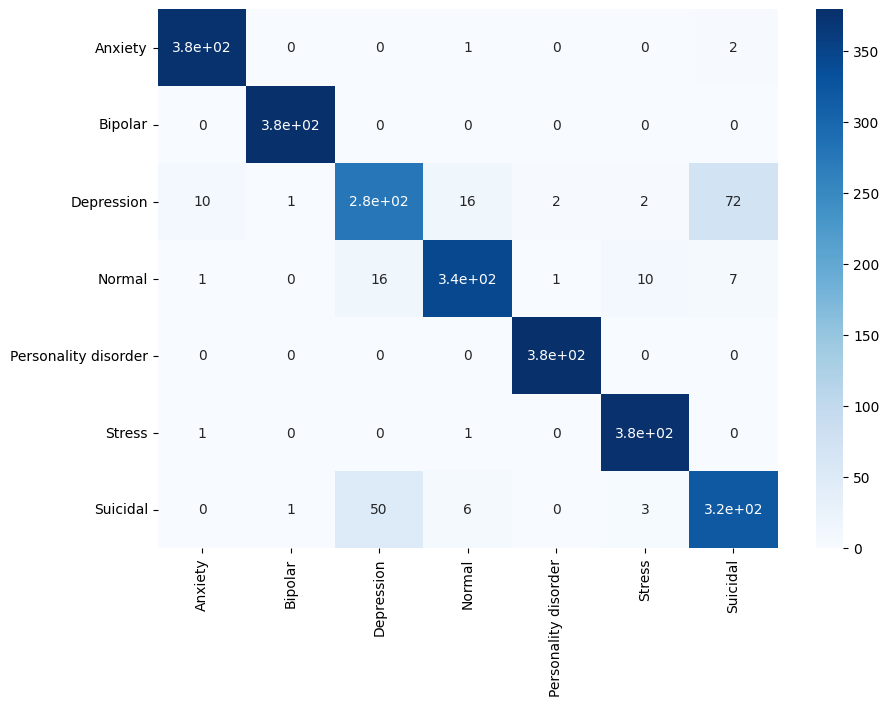

In [45]:
plt.figure(figsize=(10,7))
cm=confusion_matrix(test_labels,predictions)
sn.heatmap(cm,annot=True,cmap="Blues",xticklabels=lb.classes_,yticklabels=lb.classes_)

In [47]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [49]:
tokenizer=AutoTokenizer.from_pretrained("/content/save_model")

In [50]:
model=AutoModelForSequenceClassification.from_pretrained("/content/save_model")

In [51]:
from transformers import pipeline

In [54]:
ans=pipeline("text-classification",model=model,tokenizer=tokenizer)

Device set to use cuda:0


In [55]:
ans("my person is clever")

[{'label': 'LABEL_3', 'score': 0.9929463267326355}]